#### This HARK demo shows one great use of HARK: importing and solving a model for different parameter values, to see how parameters affect the solution.

Specifically, it examines the Marginal Propensity to Consume (MPC) derived from an increase in a credit limit, and compares it to the MPC derived from temporary income. 

The code is structured to facilitate understanding the program. So, rather than import modules at the beginning of the script, they are imported in the body to make their purpose more obvious. 



**Step** 1: Tell Python where to find the main HARK scripts (such as <font color='green'>HARKcore.py</font>) and the ConsumptionSaving scripts (such as <font color='green'>ConsIndShockModel.py</font>)

In [1]:
import sys
import os

In [2]:
sys.path.insert(1,'/home/marc/Git/HARK/ConsumptionSaving') #replace path in single quotes with
# your path to ConsumptionSaving folder
sys.path.insert(1, os.path.abspath('/home/marc/Git/HARK')) #replace path in single quotes with 
# your path to main HARK folder

__Step 2__: Bring in an agent making a consumption/ savings decision every period, subject to transitory and permanent income shocks,

In [3]:
from ConsIndShockModel import IndShockConsumerType
import ConsumerParameters as Params #this imports the default parameter values

... and create an instance of the consumer type using the default parameter values. We create the instance of the consumer type by calling <span style="color:blue">IndShockConsumerType()</span> and pass the default parameter values by passing `**Params.init_idiosyncratic_shocks` as an argument:

In [4]:
BaselineExample = IndShockConsumerType(**Params.init_idiosyncratic_shocks)

divide by zero encountered in log


We have now created an instance of a very standard consumer type.<br> **Note** that many assumptions are made in creating a standard consumer type, and as with any structural model, these assumptions matter. For example, this consumer pays the same interest rate on debt as she earns on savings.

Alternatively, if we wanted to solve the problem of a consumer who pays a higher interest rate on debt than the rate earned on savings, we could easily do so by importing a *different model* from HARK and create an instance of that <font color='blue'>ConsumerType</font> instead.

To see this modification in action, simply uncomment (remove the hashtag) from the two lines of code in the block below, and see how results change.

In [5]:
#from ConsIndShockModel import KinkedRconsumerType
#BaselineExample = KinkedRconsumerType(**Params.init_kinked_R)

__Step 3__: Modify parameter values as needed.

To see all the parameters used in the model (along with their default values), see <span style="color:green">ConsumerParameters.py</span>

Parameter values are stored as attributes of the <font color='blue'>ConsumerType</font> instance. For example, the risk-free interest rate `Rfree` is stored as <span style="color:blue">BaselineExample.Rfree</span>.
Because we created <span style="color:blue">BaselineExample</span> using the default parameter values, at the moment <span style="color:blue">BaselineExample.Rfree</span> is set to the default value of `Rfree` (which, at the time this demo was written, was 1.03). 

Therefore, to modify the risk-free interest rate used in <span style="color:blue">BaselineExample</span> (say, for example, to 1.02) we simply assign a new value to the `Rfree` attribute:

In [6]:
BaselineExample.Rfree = 1.02 #modify the risk-free interest rate

We can similarly modify other attributes of the <font color='blue'>ConsumerType</font> instance (titled <span style="color:blue">BaselineExample</span>):

In [7]:
BaselineExample.CRRA = 2 #modify the coefficient of relative risk aversion
BaselineExample.BoroCnstArt = -.3 #modify the artifical borrowing constraint
BaselineExample.DiscFac = .5 #this number is chosen so that the taget debt:permanent_income ratio is approximately .1
        #ie BaselineExample.solution[0].cFunc(.9) is roughly = 1

There is one more (slightly more complicated) parameter we must modify, the "cycles" attribute. This parameter indicates *how often* the sequence of periods must be solved, 
> Imagine a consumer with an infinite horizon of periods that (ex-ante) are all identical. Conversely, imagine a consumer with a finite lifecycle; or a consumer who faces an infinite horizon of periods that are cycle but are not identical (ie a ski instructor facing an inifinite series of winter periods with significant income, but interspersed with summer periods with little income). These differences are captured via the "cycles" attribute. 

-  the default value 1 corresponds to a consumer with a finite lifecycle that is only experienced once
-  the value 2 corresponds to a consumer who lived that life twice in a row, then died
-  the value 0 corresponds to an infinite horizon consumer

One additional complication: the "cycles" attribute is not instantiated in `Params.init_idiosyncratic_shocks`. Instead, it is a keyword argument to the `__init__()`method of <span style="color:blue">IndShockConsumerType</span>.

In [8]:
BaselineExample.cycles = 0

__Step 4__: Create another consumer to compare to <span style="color:blue">BaselineExample</span>...

In [9]:
from copy import deepcopy
XtraCreditExample = deepcopy(BaselineExample) #use deepcopy to make a copy of BaselineExample with same parameter values

... and modify the parameters as needed. With <span style="color:blue">XtraCreditExample</span>, we want to see what happens if the consumer has access to more credit. To do so, we need to relax their borrowing constraint by increasing <span style="color:blue">XtraCreditExample</span>'s credit in relation to <span style="color:blue">BaselineExample</span>. First, we declare how much we want to increase credit...

In [10]:
credit_change = .001

... then we decrease <span style="color:blue">XtraCreditExample</span>'s artifical borrowing constraint by the declared amount:

In [11]:
XtraCreditExample.BoroCnstArt = BaselineExample.BoroCnstArt - credit_change

Now, we solve the consumers' problems. In HARK, this is accomplished by calling the `solve()` method of the ConsumerType.

In [12]:
BaselineExample.solve() #solve the baseline example

In [13]:
XtraCreditExample.solve() #solve the comparison example of the consumer with more credit

#### We can now compare the solutions to these two slightly different problems.
We are going to compare the consumption functions for the two consumers. Policy functions (including consumption functions) in HARK are stored as attributes of the "solution" of the `ConsumerType`. The solution is a list whose index is the time periods (thus, each list item may be a separate solution corresponding to the separate time period). 

Since the consumers in this demo follow the  infinite-horizon-with-homogeneous-periods model (remember that we set `BaselineExample.cycles = 0`), we can regard this as a single time period, and hence a single solution. Thus, `BaselineExample.solution[0]` is the sole solution for <span style="color:blue">BaselineExample</span>. If, instead, <font color='blue'>BaselineExample</font> had 10 time periods, we could access the 5th period using `BaselineExample.solution[4]` (remember that Python counts from 0). Therefore, the consumption function <font color='blue'>cFunc</font> from the solution to <font color='blue'>BaselineExample</font> is `BaselineExample.solution[0].cFunc`.

**Steps 5 - 8:**
The following steps involve plotting the consumption functions and the MPCs of the two consumers. First, we will define functions that will be used to plot the MPCs; we then import the necessary modules to plot our solutions; we then plot the consumption functions and display them; and finally, plot the MPCs and display them.

**Step 5**: Define functions to plot MPCs:

In [14]:
def FirstDiffMPC_Income(x):
    '''Approximate the MPC out of income by giving the agent a very small increase in income, and plot the proportion of 
    change that is reflected in increased consumption'''
    income_change = credit_change #declare how much we want to increase (or decrease) income
        #Here we change income by the same amount we changed credit so that the two MPC approximations are compatible
    return (BaselineExample.solution[0].cFunc(x + income_change) - BaselineExample.solution[0].cFunc(x)) / income_change
        #We then calculate the approximate MPC out of income

In [15]:
def FirstDiffMPC_Credit(x):
    '''Approximate the MPC out of credit by plotting how much more of the increased credit the agent 
    with the higher credit spends'''
    return (XtraCreditExample.solution[0].cFunc(x) - BaselineExample.solution[0].cFunc(x)) / credit_change

**Step 6**: Import the necessary modules:

In [16]:
from HARKutilities import plotFuncs
import pylab as plt
x_max = 10 #Here we declare the upper limit for the graph

**Step 7**: Plot the consumption functions to easily compare.

**Note** that `plotFuncs` takes four arguments:
1.  a list of the arguments to plot
2.  the lower bound for the plots
3.  the upper bound for the plots
4.  keywords to pass to the legend for the plot

Consumption functions:


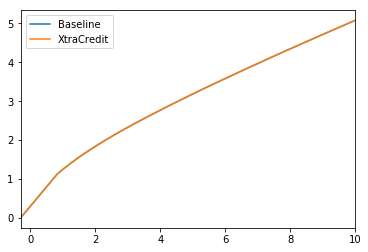

In [17]:
print('Consumption functions:')
plotFuncs([BaselineExample.solution[0].cFunc, XtraCreditExample.solution[0].cFunc],  #list args to plot
          BaselineExample.solution[0].mNrmMin,                                       #lower bound for plot
          x_max,                                                                     #upper bound for plot
          legend_kwds = {'loc':'upper left', 'labels': ["Baseline", "XtraCredit"]})  #keywords for plot legend

**Step 8**: Plot the MPCs to easily compare. See **note** about `plotFuncs` above.

MPC out of Credit v MPC out of Income:


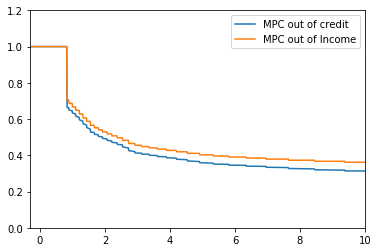

In [18]:
print('MPC out of Credit v MPC out of Income:')
plt.ylim([0.,1.2])
plotFuncs([FirstDiffMPC_Credit, FirstDiffMPC_Income],                          #list of arguments for plot
          BaselineExample.solution[0].mNrmMin,                                 #lower bound
          x_max,                                                               #upper bound
          legend_kwds = {'labels':["MPC out of credit", "MPC out of Income"]}) #keywords for plot legend